<a href="https://colab.research.google.com/github/seetvn/Flask_Form/blob/main/Copy_of_CM20315_Coursework_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coursework I -- Model hyperparameters

The goal of the coursework is to modify a simple bit of numpy code that trains a network and measures the performance on a validation set for the MNist 1D dataset. 

In this coursework, you need to modify the **model hyperparameters** (only) to improve the performance over the current attempt.  This could mean the number of layers, the number of hidden units per layer, or the type of activation function, or any combination of the three. 

The only constraint is that you MUST use a fully connected network (no convolutional networks for now if you have read ahead in the book).

You don't have to improve the performance much.  A few tenths of a percent is fine.  It just has to be better to get full marks.

You will need to upload three things to Moodle:
1.   The image that this notebook saves (click the folder icon on the left on colab to download it)
2.   The lines of code you changed
3.   The whole notebook as a .ipynb file.  You can do this on the File menu




In [ ]:
import numpy as np
import os
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import random

In [ ]:
# Run this once to copy the train and validation data to your CoLab environment 
# or download from my github to your local machine if you are doing this locally
if not os.path.exists('./train_data_x.npy'):
  !wget https://github.com/udlbook/udlbook/raw/main/practicals/train_data_x.npy
  !wget https://github.com/udlbook/udlbook/raw/main/practicals/train_data_y.npy
  !wget https://github.com/udlbook/udlbook/raw/main/practicals/val_data_x.npy
  !wget https://github.com/udlbook/udlbook/raw/main/practicals/val_data_y.npy  

In [ ]:
# Load in the data
train_data_x = np.load('train_data_x.npy')
train_data_y = np.load('train_data_y.npy')
val_data_x = np.load('val_data_x.npy')
val_data_y = np.load('val_data_y.npy')
# Print out sizes
print("Train data: %d examples (columns), each of which has %d dimensions (rows)"%((train_data_x.shape[1],train_data_x.shape[0])))
print("Validation data: %d examples (columns), each of which has %d dimensions (rows)"%((val_data_x.shape[1],val_data_x.shape[0])))

Train data: 4000 examples (columns), each of which has 40 dimensions (rows)
Validation data: 2000 examples (columns), each of which has 40 dimensions (rows)


Define the network

In [ ]:


# There are 40 input dimensions and 10 output dimensions for this data
# The inputs correspond to the 40 offsets in the MNIST1D template.
D_i = 40
# The outputs correspond to the 10 digits
D_o = 10

# Number of hidden units in layers 1 and 2
D_1 = 200
D_2 = 200
D_3=200
D_4=200

# create model with two hidden layers
model = nn.Sequential(
nn.Linear(D_i, D_1),
nn.ReLU(),
nn.Linear(D_1, D_2),
nn.ReLU(),
nn.Linear(D_2, D_3),
nn.ReLU(),
nn.Linear(D_3,D_4),
nn.ReLU(),
nn.Linear(D_4,D_o))

In [ ]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

In [ ]:
# You need all this stuff to ensure that PyTorch is deterministic
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

Epoch     0, train loss 1.536081, train error 60.12,  val loss 1.651674, percent error 66.10
Epoch     1, train loss 1.222735, train error 46.30,  val loss 1.458209, percent error 57.00
Epoch     2, train loss 0.949765, train error 33.38,  val loss 1.324991, percent error 49.25
Epoch     3, train loss 0.755701, train error 27.05,  val loss 1.237975, percent error 46.30
Epoch     4, train loss 0.627336, train error 23.62,  val loss 1.235443, percent error 44.80
Epoch     5, train loss 0.476979, train error 18.12,  val loss 1.210164, percent error 42.10
Epoch     6, train loss 0.383687, train error 13.00,  val loss 1.241652, percent error 40.50
Epoch     7, train loss 0.302607, train error 9.88,  val loss 1.242512, percent error 39.55
Epoch     8, train loss 0.280486, train error 10.10,  val loss 1.298706, percent error 38.95
Epoch     9, train loss 0.177214, train error 5.62,  val loss 1.339733, percent error 37.95
Epoch    10, train loss 0.049953, train error 0.60,  val loss 1.224023, 

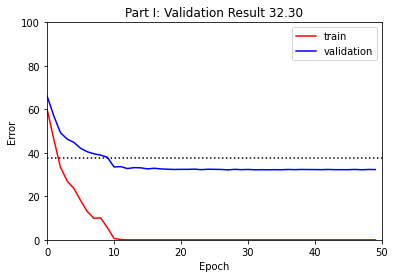

In [ ]:
# Set seed so always get same result (do not change)
set_seed(1)

# choose cross entropy loss function (equation 5.24 in the loss notes)
loss_function = nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 10 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
# create 100 dummy data points and store in data loader class
x_train = torch.tensor(train_data_x.transpose().astype('float32'))
y_train = torch.tensor(train_data_y.astype('long'))
x_val= torch.tensor(val_data_x.transpose().astype('float32'))
y_val = torch.tensor(val_data_y.astype('long'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 50
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_val = np.zeros((n_epoch))
errors_val = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, data in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = data
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the lss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_val = model(x_val)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_val_class = torch.max(pred_val.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_val[epoch]= 100 - 100 * (predicted_val_class == y_val).float().sum() / len(y_val)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_val[epoch]= loss_function(pred_val, y_val).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  val loss {losses_val[epoch]:.6f}, percent error {errors_val[epoch]:3.2f}')
  
  # tell scheduler to consider updating learning rate
  scheduler.step()

# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_val,'b-',label='validation')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('Part I: Validation Result %3.2f'%(errors_val[-1]))
ax.legend()
ax.plot([0,n_epoch],[37.45, 37.45],'k:') # Original results. You should be better than this!
plt.savefig('Coursework_I_Results.png',format='png')
plt.show()

In [ ]:
# Leave this all commented for now
# We'll see how well you did on the test data after the coursework is submitted

# if not os.path.exists('./test_data_x.npy'):
#   !wget https://github.com/udlbook/udlbook/raw/main/practicals/test_data_x.npy
#   !wget https://github.com/udlbook/udlbook/raw/main/practicals/test_data_y.npy


# # I haven't given you this yet, leave commented
# test_data_x = np.load('test_data_x.npy')
# test_data_y = np.load('test_data_y.npy')
# x_test = torch.tensor(test_data_x.transpose().astype('float32'))
# y_test = torch.tensor(test_data_y.astype('long'))
# pred_test = model(x_test)
# _, predicted_test_class = torch.max(pred_test.data, 1)
# errors_test = 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
# print("Test error = %3.3f"%(errors_test))